In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils.video import FPS
import imutils
from threading import Thread

In [2]:
def display_img(disp_img):
    cv2.imshow('img_display',disp_img)
    cv2.waitKey(0)

In [3]:
def plot_img(img):
    plt.imshow(img)
    plt.show()

In [4]:
def read_img(img,chn=3):
    img_read = cv2.imread(img,chn)
    #display_image(img_read)
    return img_read

In [5]:
def img_cvt2gray(img):
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray_img

In [6]:
def canny_edge_detection(img):
    #gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plot_img(grey_img)
    #G_Blur_img = cv2.GaussianBlur(grey_img,(7,7), 1.8)
    G_Blur_img = cv2.GaussianBlur(img,(3,3), 0.7)
    #bilateral = cv2.bilateralFilter(gray_img, 0, 30, 30)
    canny_edges = cv2.Canny(G_Blur_img, 50, 130)
    #plot_img(canny_edges)
    return canny_edges

In [7]:
def region_of_interest(img,polyPoints):
    mask_img = np.zeros_like(img)
    height,width = img.shape
    #print("height {},width {}".format(height,width))
    roi = cv2.fillPoly(mask_img,np.array([polyPoints]), (250,0,0))
    roi_merged_img = cv2.bitwise_and(img,roi)
    return roi_merged_img

In [8]:
def display_lines(img,lines):
    mask_img = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            #x1,y1,x2,y2 = line.reshape(4) # convert 2d-array into 1-d array
            x1,y1,x2,y2 = line
            cv2.line(mask_img, (x1,y1), (x2,y2), (255,0,0), 10)
    
    merged_img = cv2.addWeighted(img,0.8,mask_img,1,1)
    return merged_img

In [9]:
def make_line(img, line_coefficient):
    #print("line_coefficient",line_coefficient)
    slope = line_coefficient[0]
    intercept = line_coefficient[1]    
    y1 = img.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    line = np.array([x1,y1,x2,y2])
    return line

In [10]:
def average_slope_intercept(img,lines):
    left_line = []
    right_line = []
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4) # convert 2d-array into 1-d array    
            slope,intercept = np.polyfit((x1,x2),(y1,y2),1)
            #print ("slope",slope)
            #print ("intercept",intercept)             
            if slope < 0:
                left_line.append((slope,intercept))
            else:
                right_line.append((slope,intercept))

        #print ("left_line",left_line)
        #print ("right_line",right_line)        
        left_fit_avg = np.average(left_line,axis=0)
        right_fit_avg = np.average(right_line,axis=0)
        #print ("left_fit_avg",left_fit_avg)
        #print ("right_fit_avg",right_fit_avg)
        left_line = make_line(img, left_fit_avg)    
        right_line = make_line(img, right_fit_avg)
    return(np.array([left_line,right_line]))

In [11]:
def save_img(img,img_path='img.jpg'):
    cv2.imwrite(img_path,img)

In [12]:
def remove_nonLaneLine(T, image):
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    maskImg = np.copy(image)
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            if maskImg[y, x] >= T:
                maskImg[y, x] = 0 

            # return the thresholded image
    return maskImg

In [13]:
def imgInversion(grayImg):
    #imgInv = cv2.bitwise_not(gray_img)
    ThresImg = remove_nonLaneLine(70, imgInv)
    expImg_Inv = cv2.bitwise_and(imgInv,ThresImg)
    return expImg_Inv

In [68]:
G_Blur_img = cv2.GaussianBlur(expImg,(3,3),0.7)
#bilateral = cv2.bilateralFilter(gray_img, 0, 30, 30)
canny_img = cv2.Canny(G_Blur_img, 50, 130)
display_img(canny_img)

In [81]:
lines = [(400,300),# Top-left corner 
              (0, 540), # Bottom-left corner            
              (900,540), # Bottom-right corner
              (595,300)] # Top-right corner
roi_img = region_of_interest(canny_img,lines)
display_img(roi_img)

In [82]:
img_cpy = cv2.imread('assignment_4/test.jpg')
houghLines = cv2.HoughLinesP(roi_img, 3, np.pi / 180, 51,None, 45, 30)
#print (houghLines)

In [88]:
avg_lines = average_slope_intercept(grey_img,houghLines)
print (avg_lines)
lines_img = display_lines(img_cpy,avg_lines)
display_img(lines_img)

[[ 20 540 411 324]
 [848 540 603 324]]


In [47]:
cap = cv2.VideoCapture('assignment_4/Lane_video.mp4')
while(1): 
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    gray_img = img_cvt2gray(frame)
    imgInv = cv2.bitwise_not(gray_img)
    h = frame.shape[0]
    w = frame.shape[1]
    #ThresImg = remove_nonLaneLine(70, imgInv)
    #expImg_Inv = cv2.bitwise_and(imgInv,ThresImg)    
    #inv_img = imgInversion(gray_img)
    canny_img = canny_edge_detection(gray_img)
    Lines = [(400,300),# Top-left corner 
              (0, 540), # Bottom-left corner            
              (900,540), # Bottom-right corner
              (595,300)] # Top-right corner
    roi_img = region_of_interest(canny_img,Lines)# crops roi from lane image
    houghLines = cv2.HoughLinesP(roi_img, 3, np.pi / 180, 45,None, 30, 15)
    #print ('houghLines :',houghLines)
    avg_lines = average_slope_intercept (frame,houghLines)
    lines_img = display_lines(frame,avg_lines)    
    cv2.imshow("ImageRegion", lines_img) 
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [39]:
cap = cv2.VideoCapture('assignment_4/Lane_video.mp4') #capture the video
#cap.set(cv2.CAP_PROP_FPS, 100)
while(1): # if the video capture object is initialised
    success,frame = cap.read() # reads the captured video and returns the frame
    #fps = FPS().start()
    # Canny edge detection is 2nd order derivative and edges are very sharp compared to other edge filters
    #plot_img(frame)
    #print('New Line')
    #height,width = frame.shape[:2]
    if not success:
        print('No frames grabbed!')
        break
    gray_img = img_cvt2gray(frame)
    inv_img = imgInversion(gray_img)
    canny_img = canny_edge_detection(inv_img) # returns edges from the frame
    #grey_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #plot_img(grey_img)
    #lines = [(0,height),(450,260),(920,height)]
    Lines = [(400,300),# Top-left corner 
              (0, 540), # Bottom-left corner            
              (900,540), # Bottom-right corner
              (595,300)] # Top-right corner
    roi_img = region_of_interest(canny_img,Lines)# crops roi from lane image
    #display_img(roi_img)
    #break
    houghLines = cv2.HoughLinesP(roi_img, 3, np.pi / 180, 45,None, 30, 15)
    #print ('houghLines :',houghLines)
    avg_lines = average_slope_intercept (frame,houghLines)
    lines_img = display_lines(frame,avg_lines)

    cv2.imshow("ImageRegion", lines_img)    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #fps.update()


#fps.stop()
#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture('assignment_4/Lane_detect.avi') #capture the video
while(cap.isOpened()): # if the video capture object is initialised
    _,frame = cap.read() # reads the captured video and returns the frame
    # Canny edge detection is 2nd order derivative and edges are very sharp compared to other edge filters
    #plot_img(frame)
    #print('New Line')
    height,width = frame.shape[:2]
    canny_img = canny_edge_detection(frame) # returns edges from the frame
    #grey_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #plot_img(grey_img)
    lines = [(0,height),(920,height),(400,290)]
    roi_img = region_of_interest(canny_img,lines)# crops roi from lane image
    #display_img(roi_img)
    #break
    houghLines = cv2.HoughLinesP(roi_img, 3, np.pi / 180, 45,None, 30, 15)
    #print ('houghLines :',houghLines)
   
    lines_img = display_lines(frame,avg_lines)
    display_img(lines_img)
    #break
    cv2.imshow('lines_img',canny_img)
    if cv2.waitKey(1) == ord('q'): #wait for 1ms between each fame
        break
print("End")
cap.release()
cv2.destroyAllWindows()

In [11]:
def recal_line(frame_recal,image_n_recal,canny_img_recal,polyLines):
    print("image_n_recal: ",image_n_recal)
    error_img_recal = 'assignment_4/error_'+str(image_n_recal)+'.jpg'
    save_img(frame_recal,error_img)
    roi_img_recal = region_of_interest(canny_img_recal,polyLines)
    plot_img(roi_img_recal)
    houghLines_recal = cv2.HoughLinesP(roi_img_recal, 3, np.pi / 180, 45,None, 30, 15)
    avg_lines_recal = average_slope_intercept (frame,houghLines_recal)
    return avg_lines_recal

In [ ]:
image_n = 1
cap = cv2.VideoCapture('assignment_4/Lane_video.mp4') #capture the video
while(cap.isOpened()): # if the video capture object is initialised
    _,frame = cap.read() # reads the captured video and returns the frame
    # Canny edge detection is 2nd order derivative and edges are very sharp compared to other edge filters
    #plot_img(frame)
    #print('New Line')
    height,width = frame.shape[:2]
    canny_img = canny_edge_detection(frame) # returns edges from the frame
    #grey_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #plot_img(grey_img)
    lines = [(0,height),(920,height),(400,290)]
    roi_img = region_of_interest(canny_img,lines)# crops roi from lane image
    #display_img(roi_img)
    #break
    houghLines = cv2.HoughLinesP(roi_img, 3, np.pi / 180, 45,None, 30, 15)
    #print ('houghLines :',houghLines)
    try:
        avg_lines = average_slope_intercept (frame,houghLines)
    except Exception as err:
        print("Recalculation of line")
        print("image_n: ",image_n)
        error_img = 'assignment_4/error_'+str(image_n)+'.jpg'
        roiEr_img = 'assignment_4/roiEr_'+str(image_n)+'.jpg'
        lines_1 = [(0,500),(450,260),(920,500)]
        avg_lines = recal_line(frame,image_n,canny_img,lines_1)
        #plot_img(roi_img)
        #plot_img(roi_img1)
        #save_img(roi_img1,roiEr_img)
        image_n += 1
        #break
    lines_img = display_lines(frame,avg_lines)
    #display_img(lines_img)
    #break
    #cv2.imshow('lines_img',lines_img)
    if cv2.waitKey(1) == ord('q'): #wait for 1ms between each fame
        break
print("End")
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
cap.release()
cv2.destroyAllWindows()

In [161]:
lines = [(0,height),(920,height),(400,290)]
lines

[(0, 540), (920, 540), (400, 290)]

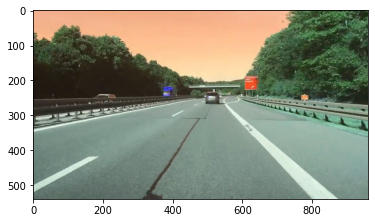

In [185]:
err_img = cv2.imread('assignment_4/error_1.jpg')
plot_img(err_img)

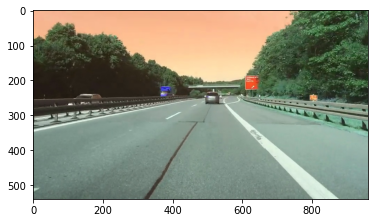

In [186]:
err_img = cv2.imread('assignment_4/error_2.jpg')
plot_img(err_img)